<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Curriculum learning algorithm:
# Train the model on easier dataset
# once satisfactory results are achieved, alter the dataset and merge the dataset with tougher examples
# Consider 12 buckets with mean as 0.1, 0.2..... and variance as 0.1 and 0.5


# About noise: Increasing the mean makes the image whiter, like effect of flash, it retains the actual shape of the face
#               Increasing the sigmoid, adds noise
# Currently on:
## Bucket 1: white noise, mean = 0.0, variance = 0.05, PSNR = 31.04, randomness added 
## Bucket 2: white noise, mean = 0.0, variance = 0.12, PSNR = 23.71, randomness added 
# Bucket 3: white noise, mean = 0.0, variance = 0.25, PSNR = 19.61, randomness added  
# Bucket 4: white noise, mean = 0.0, variance = 0.4, PSNR = 14.48, randomness added  
# Bucket 5: white noise, mean = 0.0, variance = 0.55, PSNR = ?, randomness added 
# Bucket 6: white noise, mean = 0.0, variance = 0.65, PSNR = ?, randomness added 
# Bucket 7: white noise, mean = 0.0, variance = 0.8, PSNR = ?, randomness added 
# Bucket 8: white noise, mean = 0.0, variance = 0.95, PSNR = ?, randomness added 

# Model v5
    # 120 epochs per training bucket
    # total 8 buckets each having a size of 300 examples
    # Change learning rate and momentum after 50, 90 epochs, lr = [0.01, 0.01, 0.001], and momentum = [0.2, 0.4, 0.6]
    # start lr = 0.01, momentum = 0.2

# Future works
# Add harder examples

In [1]:
import os
import time
import random
import datetime
import pytz

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
#images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
#dictionary[person] = image_value

#Data description: Total facial images of 105 people with each person having a total of 6 images
# Input given as the file id of the file stored in drive
image_data = load_drive_data('1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g')
images = dict_to_array(image_data)

In [5]:
del(image_data)
images.shape

(630, 224, 224, 3)

In [6]:
#add noise to these facial images
# Algorithm 1, Add White Noise
def add_noise(images, mean=0., sigmoid=0.3, clip=True, return_params=False, add_random=True):
    
    random = np.random.rand(images.shape[0], images.shape[1], images.shape[2], images.shape[3])
    dist = np.random.normal(loc=mean, scale=sigmoid, size=images.shape)
    
    # print(images.shape, random.shape, dist.shape)

    if add_random:
        noise = random * dist
        images_noise = images + noise

    else:
        noise = dist
        images_noise = images + dist

    if clip:
        images_noise = np.clip(images_noise, 0.0, 1.)
    
    if return_params:
        return images_noise, noise
    
    return images_noise


#Algorithm 2
#First zoom the input image and then regenerate it to create the blur effect
#The blur effect here is because of loss of pixel values during reconstruction
def zoom_blur(images, zoom_size=50, actual_size=224):

    blur_imgs = []
    for img in images:
        blur_imgs.append(cv2.resize(cv2.resize(img, (zoom_size, zoom_size)), (actual_size, actual_size)))
    
    return np.array(blur_imgs)


#find mean value of the 4 dimensional array
def find_mean(images):

    new_images = np.reshape(images, (images.shape[0]*images.shape[1]*images.shape[2]*images.shape[3]))
    return np.abs(np.mean(new_images))

#Find percent of noise in image set : Image set is 4 dimensional
#input is the noisy image and the noise that is added to the image
def find_percent(actual_images, noisy_images):

    # Find dataset mean
    noisy_mean, actual_mean = find_mean(noisy_images), find_mean(actual_images)

    #Find the shape of the noise, and then reshape the image to (1, batch*x*y*z) to find error
    shape = noisy_images.shape
    noisy_images = np.reshape(noisy_images, (shape[0]*shape[1]*shape[2]*shape[3], ))
    actual_images = np.reshape(actual_images, (shape[0]*shape[1]*shape[2]*shape[3]), )
    
    # Shifted the images to encounter the divison by 0 error
    noise, actual = noisy_images + noisy_mean, actual_images + actual_mean

    #Return percentage of noise
    return np.mean(np.abs((noise - actual)/(noise)))

#Tensorflow function to find psnr of an image
def psnr(y_true, y_pred):

    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

Actual Image


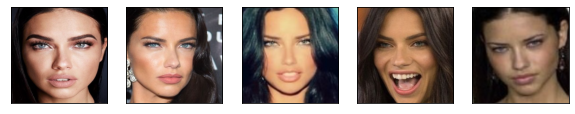

Noisy Image


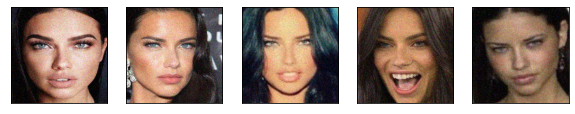

tf.Tensor(23.715372, shape=(), dtype=float32)
Precent: 6.651225805397226


In [79]:
#Visualizing the effects of blur
print("Actual Image")
plot(images[:5])

print("Noisy Image")

sigmoid = 0.12
plot(add_noise(images[:5], mean=0., sigmoid=sigmoid))
print(psnr(images[: 5], add_noise(images[:5], mean=0., sigmoid=sigmoid)))
print("Precent:", find_percent(images[:5], add_noise(images[:5], mean=0., sigmoid=sigmoid))*100)

# print("Zoom Blur")
# plot(zoom_blur(images[:5], zoom_size=40))

In [80]:
#Store different sets of images in each variable and then combine them to make the training dataset

#Do not consider all the images but only a subset for memory reasons
bucket_size = 300

# Create the input and output dataset
# first bucket has images from 0 to 300 and 2nd bucket has data from 300 to 600, continue the same for further 
bucket = np.concatenate((add_noise(images[: bucket_size], mean=0.0, sigmoid=0.05),
                         add_noise(images[bucket_size: 2*bucket_size], mean=0.0, sigmoid=0.12)))

bucket_op = np.concatenate((images[: bucket_size], images[bucket_size: 2*bucket_size]))

# For 1st stage
# bucket = add_noise(images[:bucket_size], mean=0.0, sigmoid=0.05, return_params=False)
# bucket_op = images[: bucket_size]

print("Bucket Filled", bucket.shape, bucket_op.shape)

Bucket Filled (600, 224, 224, 3) (600, 224, 224, 3)


In [81]:
print("Bucket Data")
print(find_percent(bucket_op, bucket)*100)
print(psnr(bucket_op, bucket))

Bucket Data
4.146192536652966
tf.Tensor(27.28394, shape=(), dtype=float32)


In [82]:
#Combined these noisy images to make the input images and the actual images as the output images
# bucket = np.concatenate((bucket1, bucket2))
# bucket_op = np.concatenate((images, images))

noisy_images = bucket
clear_images = bucket_op

In [83]:
# gaussian_blur.shape, normal_blur.shape, noisy_images.shape, clear_images.shape
noisy_images.shape, clear_images.shape

((600, 224, 224, 3), (600, 224, 224, 3))

In [84]:
#To clear memory

del(bucket)
del(bucket_op)

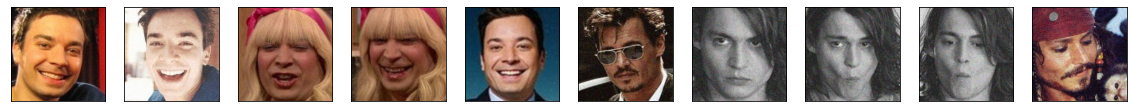

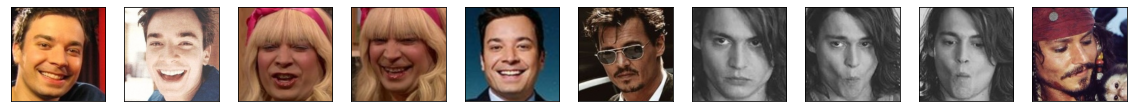

tf.Tensor(27.28394, shape=(), dtype=float32)


In [85]:
plot(noisy_images[295: 305], figsize=(20,20))
plot(clear_images[295: 305], figsize=(20,20))
print(psnr(clear_images, noisy_images))

In [14]:
def create_model():

    input_img = Input(shape=(224, 224, 3), dtype='float32')
    
    #1st Convolution Layer with Batch Normalization
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    
    #2nd Convolution Layer without Batch Normalization
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    
    #3rd Conv Layer
    x = Conv2D(3, (5, 5), activation='relu', padding='same')(x)
    
    model = Model(input_img, x)
    
    return model

In [15]:
model = create_model()

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      15616     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 3)       2403      
Total params: 20,355
Trainable params: 20,227
Non-trainable params: 128
_________________________________________________________________


In [86]:
model_path = '/content/Image_Denoising_v5_Bucket1_120epochs.h5'
model.load_weights(model_path)

In [87]:
#Training Phase: input = train_noisy, output = train_clear
#Test Phase: input = test_noisy, output = test_clear
train_noisy, test_noisy, train_clear, test_clear = train_test_split(noisy_images, clear_images, test_size=0.1)

In [88]:
# Dataset Statistics

print(find_percent(test_clear, test_noisy), find_percent(train_clear, train_noisy))
print(find_mean(test_noisy), find_mean(train_noisy))
print(psnr(test_clear, test_noisy), psnr(train_clear, train_noisy))

0.046299204804334956 0.04095873019994608
0.4043775571181811 0.4360369212946306
tf.Tensor(26.971401, shape=(), dtype=float32) tf.Tensor(27.318666, shape=(), dtype=float32)


In [89]:
# To save ram
del(noisy_images)
del(clear_images)

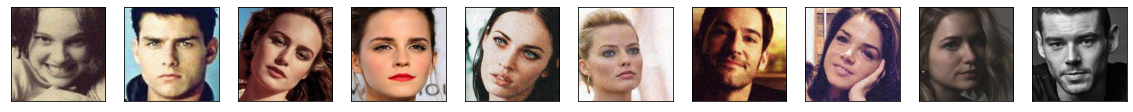

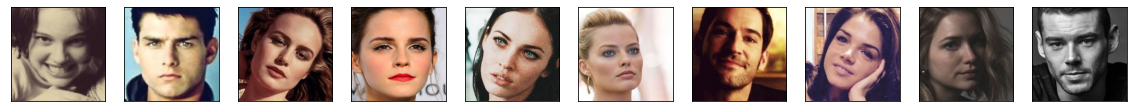

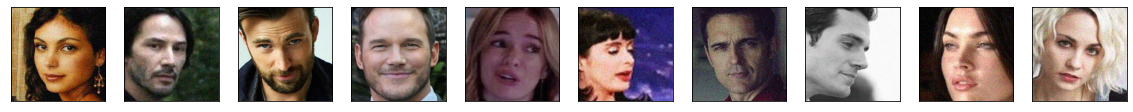

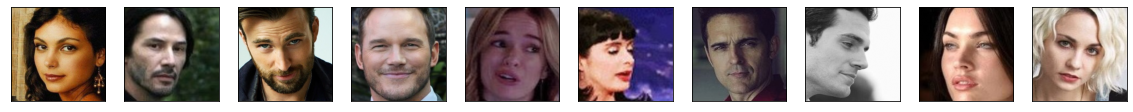

(540, 224, 224, 3) (60, 224, 224, 3)


In [90]:
plot(train_noisy[:10], figsize=(20, 20))
plot(train_clear[:10], figsize=(20, 20))
plot(test_noisy[:10], figsize=(20, 20))
plot(test_clear[:10], figsize=(20, 20))

print(train_noisy.shape, test_noisy.shape)

In [21]:
def cosine_dist(y_true, y_pred):
    return tf.reduce_mean(tf.abs(tf.losses.cosine_similarity(y_true, y_pred)))

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

def model_loss(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred) + (1 - cosine_dist(y_true, y_pred)))

In [57]:
# Code to save logs

# Model is the tensorflow/keras model
# history is the dictionary returned after model training
# logs are stored as a dictionary with key as the model_name, date and time
# Buket number is string
def save(model=None, history=None, name="Image_Denoising_v4.1.h5", bucket_num=None, logs=None, logfile_name=None, save_logs=False, print_feedback=False):

    # Selected the timezone to save logs according to IST
    tz = pytz.timezone("Asia/Kolkata")

    if model and name:
        model.save(name)
        if print_feedback:
            print("Model Saved")

    elif model:
        model.save("Image_Denoising.h5")
        if print_feedback:
            print("Model Saved")
    
    if history:
        logs[f'Bucket{bucket_num}_logs_{datetime.datetime.now(tz)}'] = history.history
        if print_feedback:
            print("History Saved in logs")

    if save_logs:
        with open(logfile_name, 'ab') as file:
            pickle.dump({'logs': logs}, file)
        if print_feedback:
            print("Logs Saved and are ready to be downloaded")
    return True

#Load the logfile
def load(model=None, model_name=None, logfile_name=None):

    if model and model_name:
        model.load(model_name)
        print("model loaded")
    if logfile_name:
        with open(logfile_name, 'rb') as file:
            temp_logs = pickle.load(file)

        print("Log file loaded in the form of a dictionary")

        return temp_logs['logs']

    return True

# Training and validation data are tuples where (input, output)
# save_after gives the number of epochs after which the data is to be saved
# Compile the model before passing in as a parameter
def train_model(model, training_data, validation_data, epochs, batch_size, save_after=10, logs=None, model_name=None, bucket_num=None, epochs_done=0):

    x_input, y_input = training_data[0], training_data[1]

    # Selected the timezone to save logs according to IST
    tz = pytz.timezone("Asia/Kolkata")

    # train model for epochs = save_after, for epochs//save_after amount of time.
    # To track the number of iterations done
    count = 0

    # If all this data is provided only then save the model, else train it normally but dont save it
    if save_after:

        for _ in range(epochs//save_after):

            history = model.fit(x_input, y_input, validation_data=validation_data, epochs = save_after, batch_size=batch_size)

            # Save the model and the history object
            save(model=model, history=history, name=f'{model_name}_Bucket{bucket_num}_{(count+1)*save_after+epochs_done}epochs.h5', 
                 bucket_num=bucket_num, logs=logs, logfile_name=f'logfile_{datetime.datetime.now(tz)}.pickle', save_logs=True)
            
            print(f'\nModel Saved after: {(count+1)*save_after+epochs_done} epochs')
            print(f'Keys in logfile: {logs.keys()}\n')

            count += 1
        
        if count*save_after < epochs:

            history = model.fit(x_input, y_input, validation_data=validation_data, epochs = epochs-count*save_after, batch_size=batch_size)

            # Save the model and the history object
            save(model=model, history=history, name=f'{model_name}_Bucket{bucket_num}_{epochs+epochs_done}epochs.h5',
                 bucket_num=bucket_num, logs=logs, logfile_name=f'logfile_{datetime.datetime.now(tz)}.pickle', save_logs=True)
            
            print(f'\nModel Saved after: {epochs+epochs_done} epochs')
            print(f'Keys in logfile: {logs.keys()}\n')

    else:
        history = model.fit(x_input, y_input, validation_data=validation_data, epochs = epochs, batch_size=batch_size)
        return history

    return True    


In [93]:
# to load logfile
# logs = {}
# logs = load(logfile_name='/log_file v5.pickle')
print(logs.keys())

# print(load(logfile_name='/content/logfile_2020-12-17 15:23:24.772351+05:30.pickle').keys())

dict_keys(['Bucket1_logs_2020-12-17 12:38:39.601990+05:30', 'Bucket1_logs_2020-12-17 13:18:43.968393+05:30', 'Bucket1_logs_2020-12-17 13:57:20.381427+05:30', 'Bucket1_logs_2020-12-17 14:30:16.354719+05:30', 'Bucket1_logs_2020-12-17 15:23:24.792604+05:30'])


In [94]:
# Optimizer used: Stochastic Gradient Descent
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.2, nesterov=False, name="SGD"
)

# Loss = mse + cosine, metric = psnr
loss = model_loss
metrics = [psnr, mse]

# Epoch to be done, save after how many epochs and how many epochs are done previously in the bucket: max = 120
epochs = 50
save_after = 25
epochs_done = 0

batch_size = 64
bucket_num = 2
model_name = "Image_Denoising_v5.1"

In [95]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# history = model.fit(train_noisy, train_clear, validation_data=(test_noisy, test_clear), epochs=epochs, batch_size=batch_size)
train_model(model, (train_noisy, train_clear), validation_data=(test_noisy, test_clear), epochs=epochs, batch_size=batch_size,
            save_after=save_after, logs=logs, model_name=model_name, bucket_num=bucket_num, epochs_done=epochs_done)

Epoch 1/25
9/9 [==============================] - 179s 20s/step - loss: 0.0184 - psnr: 22.7366 - mse: 0.0058 - val_loss: 0.0179 - val_psnr: 22.0873 - val_mse: 0.0066
Epoch 2/25
9/9 [==============================] - 181s 20s/step - loss: 0.0166 - psnr: 23.1214 - mse: 0.0054 - val_loss: 0.0308 - val_psnr: 19.4109 - val_mse: 0.0122
Epoch 3/25
9/9 [==============================] - 178s 20s/step - loss: 0.0187 - psnr: 22.3576 - mse: 0.0064 - val_loss: 0.0181 - val_psnr: 21.9617 - val_mse: 0.0068
Epoch 4/25
9/9 [==============================] - 179s 20s/step - loss: 0.0166 - psnr: 23.3104 - mse: 0.0050 - val_loss: 0.0212 - val_psnr: 21.4528 - val_mse: 0.0076
Epoch 5/25
9/9 [==============================] - 181s 20s/step - loss: 0.0191 - psnr: 22.6685 - mse: 0.0059 - val_loss: 0.0218 - val_psnr: 20.7429 - val_mse: 0.0090
Epoch 6/25
9/9 [==============================] - 180s 20s/step - loss: 0.0169 - psnr: 22.9089 - mse: 0.0056 - val_loss: 0.0196 - val_psnr: 20.4639 - val_mse: 0.0096
Epoc

In [ ]:
# # after the model is trained save the model and the log file
# save(model=model, history=history, name='Image_Denoising_v4.3.h5', bucket_num="4", logs=logs, save_logs=True)
# print("Saved keys are ", logs.keys())

In [64]:
prev_model = create_model()
prev_model.load_weights('/content/Image_Denoising_v5_Bucket1_40epochs.h5')

Input Images


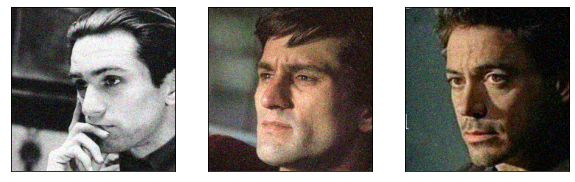

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model's Output


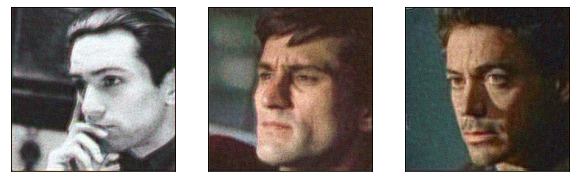


Actual Clear Image


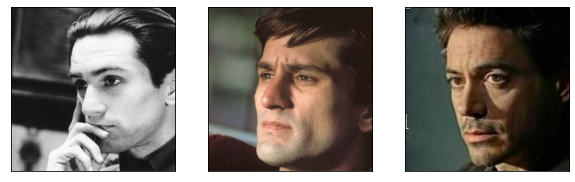

PSNR: 22.643829345703125
Noisy Image PSNR: 23.728179931640625
Previous Model PSNR: 20.352590560913086

Cosine Distance from actual image: 0.9844292998313904
Cosine Distance from Noisy Image: 0.9397093057632446
Cosine Distance of prev prediction: 0.9853672385215759

Mean of Noisy Images: 0.3298552930355072
Mean of Predicted Images: 0.3523388206958771
Mean of Actual Images: 0.32764795422554016
Mean of Previous Pred images: 0.3843275010585785

Mean error noisy image: 0.004244647920131683
Mean error pred image: 0.005541075021028519
Mean Error of previous prediction: 0.009486233815550804

Percentage of Noise:  7.675670087337494 %
Percentage of Noise in prediction:  10.948359221220016 %
Percentage of Noise in prev prediction:  17.300651967525482 %

Noisy Image Variance: 0.0713428482413292
Predicted Image Variance: 0.05912480875849724
Prev Predicted Image Variance: 0.05595516785979271


In [72]:
 #Visualize the models predictions and also the time constraints
count = 3
figsize = (10, 10)

#Input & Output Images

# Easier/ Same level as training
# Same distribution as training phase
# start = random.randint(0, test_noisy.shape[0])
# ip_imgs = test_noisy[start: start+count]
# actual_imgs = test_clear[start: start+count]

#Tougher images
# Using clear images to generate noisy images, same process as the one used to generate training images
# Previously unseen dataset
start = random.randint(500, 630)
ip_imgs, noise = add_noise(images[start: start+count], mean=0., sigmoid=0.12, return_params=True)
actual_imgs = images[start: start+count]



# make prediction on a noisy image, generate an output and plot it
# 2nd line of code to compare with previous model

pred_img = model.predict(ip_imgs)
prev_pred_img = prev_model.predict(ip_imgs)


# Converted the datatype to float32 for cosine_dist function to work: required
actual_imgs = actual_imgs.astype('float32')
ip_imgs = ip_imgs.astype('float32')
pred_img = pred_img.astype('float32')

# Plot input images
print("Input Images")
plot(ip_imgs, figsize=figsize)

# Plot predicted images
print("Model's Output")
plot(pred_img, figsize=figsize)

# Plot actual images
print("\nActual Clear Image")
plot(actual_imgs, figsize=figsize)



#Print metrics
print(f'PSNR: {psnr(actual_imgs, pred_img)}\nNoisy Image PSNR: {psnr(actual_imgs, ip_imgs)}\nPrevious Model PSNR: {psnr(actual_imgs, prev_pred_img)}')
print(f'\nCosine Distance from actual image: {cosine_dist(actual_imgs, pred_img)}\nCosine Distance from Noisy Image: {cosine_dist(actual_imgs, ip_imgs)}\nCosine Distance of prev prediction: {cosine_dist(actual_imgs, prev_pred_img)}')
print(f'\nMean of Noisy Images: {find_mean(ip_imgs)}\nMean of Predicted Images: {find_mean(pred_img)}\nMean of Actual Images: {find_mean(actual_imgs)}\nMean of Previous Pred images: {find_mean(prev_pred_img)}')
print(f'\nMean error noisy image: {mse(actual_imgs, ip_imgs)}\nMean error pred image: {mse(actual_imgs, pred_img)}\nMean Error of previous prediction: {mse(actual_imgs, prev_pred_img)}')
print("\nPercentage of Noise: ", find_percent(actual_imgs, ip_imgs)*100, "%")
print("Percentage of Noise in prediction: ", find_percent(actual_imgs, pred_img)*100, "%")
print("Percentage of Noise in prev prediction: ", find_percent(actual_imgs, prev_pred_img)*100, "%")
print(f'\nNoisy Image Variance: {np.var(ip_imgs)}\nPredicted Image Variance: {np.var(pred_img)}\nPrev Predicted Image Variance: {np.var(prev_pred_img)}')

In [44]:
def get_bucket_data(bucket_num, logs=None, get_loss=False, get_psnr=False, get_mse=False):

    train_temp, test_temp = [], []
    for key in logs.keys():
        if f'Bucket{bucket_num}' in key:
            if get_loss:
                metric = 'loss'

            if get_psnr:
                metric = 'psnr'
            
            if get_mse:
                metric = 'mse'

            for index in range(len(logs[key][metric])):
                train_temp.append(logs[key][metric][index])
                test_temp.append(logs[key][f'val_{metric}'][index])
            
    return train_temp, test_temp


def plot_curve(train_data=None, validation_data=None, name='', xlabel='', ylabel=''):

    if train_data:
        plt.plot(train_loss, label=f'Training {name}')
    
    if validation_data:
        plt.plot(test_loss, label=f'Validation {name}')

    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
    
    if name:
        plt.legend()

    plt.show()    

In [66]:
# To extract particular log from the log dictionary

# print("Available Keys => ", logs.keys())
# key_name = input("Enter key name: ")
# new_history = logs[key_name]
# train_loss, test_loss = new_history['loss'], new_history['val_loss']
# train_psnr, test_psnr = new_history['psnr'], new_history['val_psnr']


# If logs are not downloaded from the logfile, then run this line of code

# new_history = history.history
# train_loss, test_loss = new_history['loss'], new_history['val_loss']
# train_psnr, test_psnr = new_history['psnr'], new_history['val_psnr']


# If logs are to be merged before plotting
train_loss, test_loss = get_bucket_data(bucket_num=1, logs=logs, get_loss=True)
train_psnr, test_psnr = get_bucket_data(bucket_num=1, logs=logs, get_psnr=True)

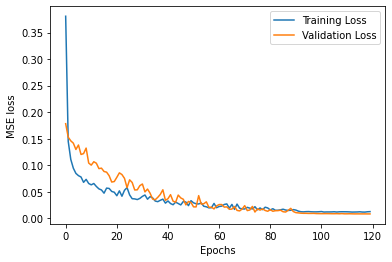

In [67]:
plot_curve(train_data = train_loss, validation_data = test_loss, name = 'loss', xlabel='Epochs', ylabel = 'MSE Loss')

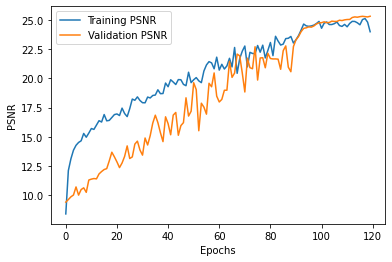

In [68]:
plot_curve(train_data = train_psnr, validation_data = test_psnr, name = 'PSNR', xlabel='Epochs', ylabel = 'PSNR')

In [ ]:
sim_model = VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
tf.reduce_sum(sim_model.predict(pred_img)), tf.reduce_sum(sim_model.predict(ip_imgs)), tf.reduce_sum(sim_model.predict(actual_imgs))

(<tf.Tensor: shape=(), dtype=float32, numpy=14430.974>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13318.311>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13426.199>)

In [ ]:
mse(255*actual_imgs, 255*pred_img), mse(255*actual_imgs, 255*ip_imgs)

(<tf.Tensor: shape=(), dtype=float32, numpy=74.78603>,
 <tf.Tensor: shape=(), dtype=float32, numpy=33.871174>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Noisy Image: 15.57233715057373
Median Filtering: 28.270381927490234
Gaussian Filtering: 25.900876998901367
Model Prediction: 25.79222869873047
	Actual			 Noisy			 Median			Gaussian		  Model


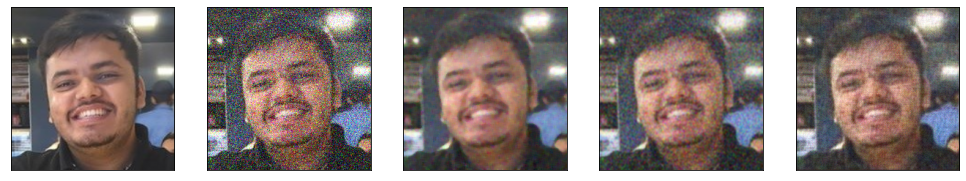

In [ ]:
test_img = cv2.imread('/profile_pic.jpg')
test_img = cv2.cvtColor(cv2.resize(test_img, (224, 224)), cv2.COLOR_BGR2RGB)
test_img = np.reshape(test_img/255, (1, 224, 224, 3))
test_blur = add_noise(np.array(test_img), mean=0., sigmoid=0.2)

new_img = np.reshape(test_blur.astype('float32'), (224, 224, 3))
median = cv2.medianBlur(new_img, 5)
gauss = cv2.GaussianBlur(new_img, (5, 5), 0)
model_pred = model.predict(test_blur)
# prev_model_pred = prev_model.predict(test_blur)

print(f'\nNoisy Image: {psnr(test_img, test_blur)}')
print(f'Median Filtering: {psnr(test_img, median)}')
print(f'Gaussian Filtering: {psnr(test_img, gauss)}')
print(f'Model Prediction: {psnr(test_img, model_pred)}')
# print(f'Prev Model Prediction: {psnr(test_img, prev_model_pred)}')

print("\tActual\t\t\t Noisy\t\t\t Median\t\t\tGaussian\t\t  Model")
plot([test_img[0], test_blur[0], median, gauss, model_pred[0]], figsize=(17, 17))